## Установка и импорты

In [21]:
# Установка зависимостей (выполните один раз при первом запуске)
!pip install simpy matplotlib numpy --quiet


[notice] A new release of pip is available: 25.0.1 -> 25.3
[notice] To update, run: python.exe -m pip install --upgrade pip


In [23]:
import simpy
import random
import numpy as np
import matplotlib.pyplot as plt
from statistics import mean

## Микросервис обработки изображений (ресурсы и процессы)
- Ресурс `workers`: GPU‑воркеры (s шт.) — основное обслуживание (инференс)
- Ресурс `preprocessors`: предобработка/валидация запроса (1–2 шт.) — быстрый шаг
- Процессы: предобработка → ожидание GPU‑воркера → инференс

In [24]:
class ImageService:
    def __init__(self, env, num_workers=4, num_preprocessors=1, mean_inference=1.5):
        self.env = env
        # GPU-воркеры (основной ресурс инференса)
        self.gpu_workers = simpy.Resource(env, capacity=num_workers)
        # Предобработка/валидация запроса (быстрый ресурс)
        self.preprocessors = simpy.Resource(env, capacity=num_preprocessors)
        self.mean_inference = mean_inference  # среднее время инференса (сек)

    def preprocess(self, request_id):
        # Быстрая предобработка/валидация запроса
        t = random.uniform(0.1, 0.2)
        yield self.env.timeout(t)

    def infer(self, request_id):
        # Инференс модели (экспоненциально распределенное время со средним mean_inference)
        t = random.expovariate(1.0 / self.mean_inference)
        yield self.env.timeout(t)
        return t

## Сбор метрик и процессы запросов

In [15]:
# Глобальные контейнеры метрик (обнуляются при каждом запуске симуляции)
waiting_times = []        # время ожидания у GPU-воркера
system_times = []         # полное время запроса в системе
service_times = []        # фактическое время инференса
in_system_time_series = []  # серия: число запросов в системе во времени
arrived = 0
served = 0

def request_process(env, rid, service: ImageService):
    global waiting_times, system_times, service_times, served
    arrival_time = env.now

    # 1) Предобработка/валидация запроса
    with service.preprocessors.request() as req_prep:
        yield req_prep
        yield env.process(service.preprocess(rid))

    # 2) Ожидание GPU-воркера и инференс
    wait_start = env.now
    with service.gpu_workers.request() as req_worker:
        yield req_worker
        wait = env.now - wait_start
        waiting_times.append(wait)
        svc = yield env.process(service.infer(rid))
        service_times.append(svc)

    # 3) Завершение обработки запроса
    total = env.now - arrival_time
    system_times.append(total)
    served += 1

def request_generator(env, service: ImageService, mean_interarrival=1.5):
    global arrived
    rid = 0
    while True:
        # Экспоненциальные интервалы между поступлениями запросов
        inter = random.expovariate(1.0 / mean_interarrival)
        yield env.timeout(inter)
        rid += 1
        arrived += 1
        env.process(request_process(env, rid, service))

def monitor_service(env, service: ImageService, dt=0.1):
    # Мониторинг числа запросов в системе (занятые GPU-воркеры + очередь)
    while True:
        num_in_system = service.gpu_workers.count + len(service.gpu_workers.queue)
        in_system_time_series.append(num_in_system)
        yield env.timeout(dt)

## Запуск симуляции и расчет метрик

In [16]:
def reset_metrics():
    global waiting_times, system_times, service_times, in_system_time_series, arrived, served
    waiting_times = []
    system_times = []
    service_times = []
    in_system_time_series = []
    arrived = 0
    served = 0

def run_simulation(num_workers=4, num_preprocessors=1, mean_inference=1.5, mean_interarrival=1.5, 
                   sim_time=2000, seed=42):
    """Запускает симуляцию микросервиса обработки изображений и возвращает метрики. Все времена — секунды."""
    reset_metrics()
    random.seed(seed)

    env = simpy.Environment()
    service = ImageService(env, num_workers=num_workers, num_preprocessors=num_preprocessors, mean_inference=mean_inference)
    env.process(request_generator(env, service, mean_interarrival=mean_interarrival))
    env.process(monitor_service(env, service, dt=0.1))
    env.run(until=sim_time)

    # Метрики
    avg_wait = mean(waiting_times) if waiting_times else 0.0
    avg_sys = mean(system_times) if system_times else 0.0
    avg_n = mean(in_system_time_series) if in_system_time_series else 0.0
    abs_thr = served / sim_time
    rel_thr = (served / arrived) if arrived > 0 else 0.0
    utilization = (sum(service_times) / (num_workers * sim_time)) if num_workers * sim_time > 0 else 0.0

    return {
        'num_workers': num_workers,
        'num_preprocessors': num_preprocessors,
        'mean_inference': mean_inference,
        'mean_interarrival': mean_interarrival,
        'sim_time': sim_time,
        'arrived': arrived,
        'served': served,
        'avg_wait': avg_wait,
        'avg_system_time': avg_sys,
        'avg_in_system': avg_n,
        'throughput_abs': abs_thr,
        'throughput_rel': rel_thr,
        'utilization': utilization
    }

def print_results(res):
    print('='*70)
    print('РЕЗУЛЬТАТЫ МОДЕЛИРОВАНИЯ (микросервис обработки изображений)')
    print('='*70)
    print(f"GPU-воркеров (s): {res['num_workers']}  | Предобработчиков: {res['num_preprocessors']}")
    print(f"Средн. межприход (μ_A): {res['mean_interarrival']} сек | Средн. инференс (μ_s): {res['mean_inference']} сек")
    print('-'*70)
    print(f"Поступило запросов: {res['arrived']} | Обработано: {res['served']}")
    print(f"Коэффициент использования (ρ): {res['utilization']:.4f} ({res['utilization']*100:.2f}%)")
    print(f"Среднее ожидание очереди: {res['avg_wait']:.4f} сек")
    print(f"Среднее время в системе: {res['avg_system_time']:.4f} сек")
    print(f"Среднее число в системе: {res['avg_in_system']:.4f}")
    print(f"Абсолютная пропускная способность: {res['throughput_abs']:.4f} req/сек")
    print(f"Относительная пропускная способность: {res['throughput_rel']:.4f}")
    print('='*70)

## Базовый запуск (по варианту): s=4, μ_s=1.5 сек, μ_A=1.5 сек

In [17]:
base = run_simulation(num_workers=4, num_preprocessors=1, mean_inference=1.5, mean_interarrival=1.5, sim_time=2000, seed=42)
print_results(base)

РЕЗУЛЬТАТЫ МОДЕЛИРОВАНИЯ (микросервис обработки изображений)
GPU-воркеров (s): 4  | Предобработчиков: 1
Средн. межприход (μ_A): 1.5 сек | Средн. инференс (μ_s): 1.5 сек
----------------------------------------------------------------------
Поступило запросов: 1341 | Обработано: 1340
Коэффициент использования (ρ): 0.2648 (26.48%)
Среднее ожидание очереди: 0.0146 сек
Среднее время в системе: 1.7538 сек
Среднее число в системе: 1.0687
Абсолютная пропускная способность: 0.6700 req/сек
Относительная пропускная способность: 0.9993


## Оптимизация по числу GPU‑воркеров
Критерии (настраиваемые): среднее ожидание < 2 сек, использование > 0.7, относительная пропускная способность > 0.95.

In [18]:
TARGET_WAIT = 2.0
TARGET_UTIL_MIN = 0.7
TARGET_REL_THR = 0.95

results_grid = []
for s in range(2, 9):  # 2..8 воркеров
    r = run_simulation(num_workers=s, num_preprocessors=1, mean_inference=1.5, mean_interarrival=1.5, sim_time=2000, seed=42)
    results_grid.append(r)

print('Оптимизация завершена. Показатели:')
for r in results_grid:
    print(f"s={r['num_workers']}: util={r['utilization']:.3f}, wait={r['avg_wait']:.3f}, relThr={r['throughput_rel']:.3f}")

# Выбор подходящих конфигураций
candidates = [r for r in results_grid if (r['avg_wait'] < TARGET_WAIT and r['utilization'] > TARGET_UTIL_MIN and r['throughput_rel'] > TARGET_REL_THR)]
best = min(candidates, key=lambda x: x['num_workers']) if candidates else None

if best:
    print('Оптимальная конфигурация (минимум воркеров, удовлетворяющая критериям):')
    print_results(best)
else:
    print('Нет конфигурации, удовлетворяющей всем критериям. Рассмотрите ослабление порогов или изменение ресурса.')

Оптимизация завершена. Показатели:
s=2: util=0.517, wait=0.409, relThr=0.998
s=3: util=0.353, wait=0.070, relThr=1.000
s=4: util=0.265, wait=0.015, relThr=0.999
s=5: util=0.212, wait=0.001, relThr=0.999
s=6: util=0.177, wait=0.000, relThr=0.999
s=7: util=0.152, wait=0.000, relThr=0.999
s=8: util=0.133, wait=0.000, relThr=0.999
Нет конфигурации, удовлетворяющей всем критериям. Рассмотрите ослабление порогов или изменение ресурса.


## Визуализация метрик в зависимости от числа GPU‑воркеров

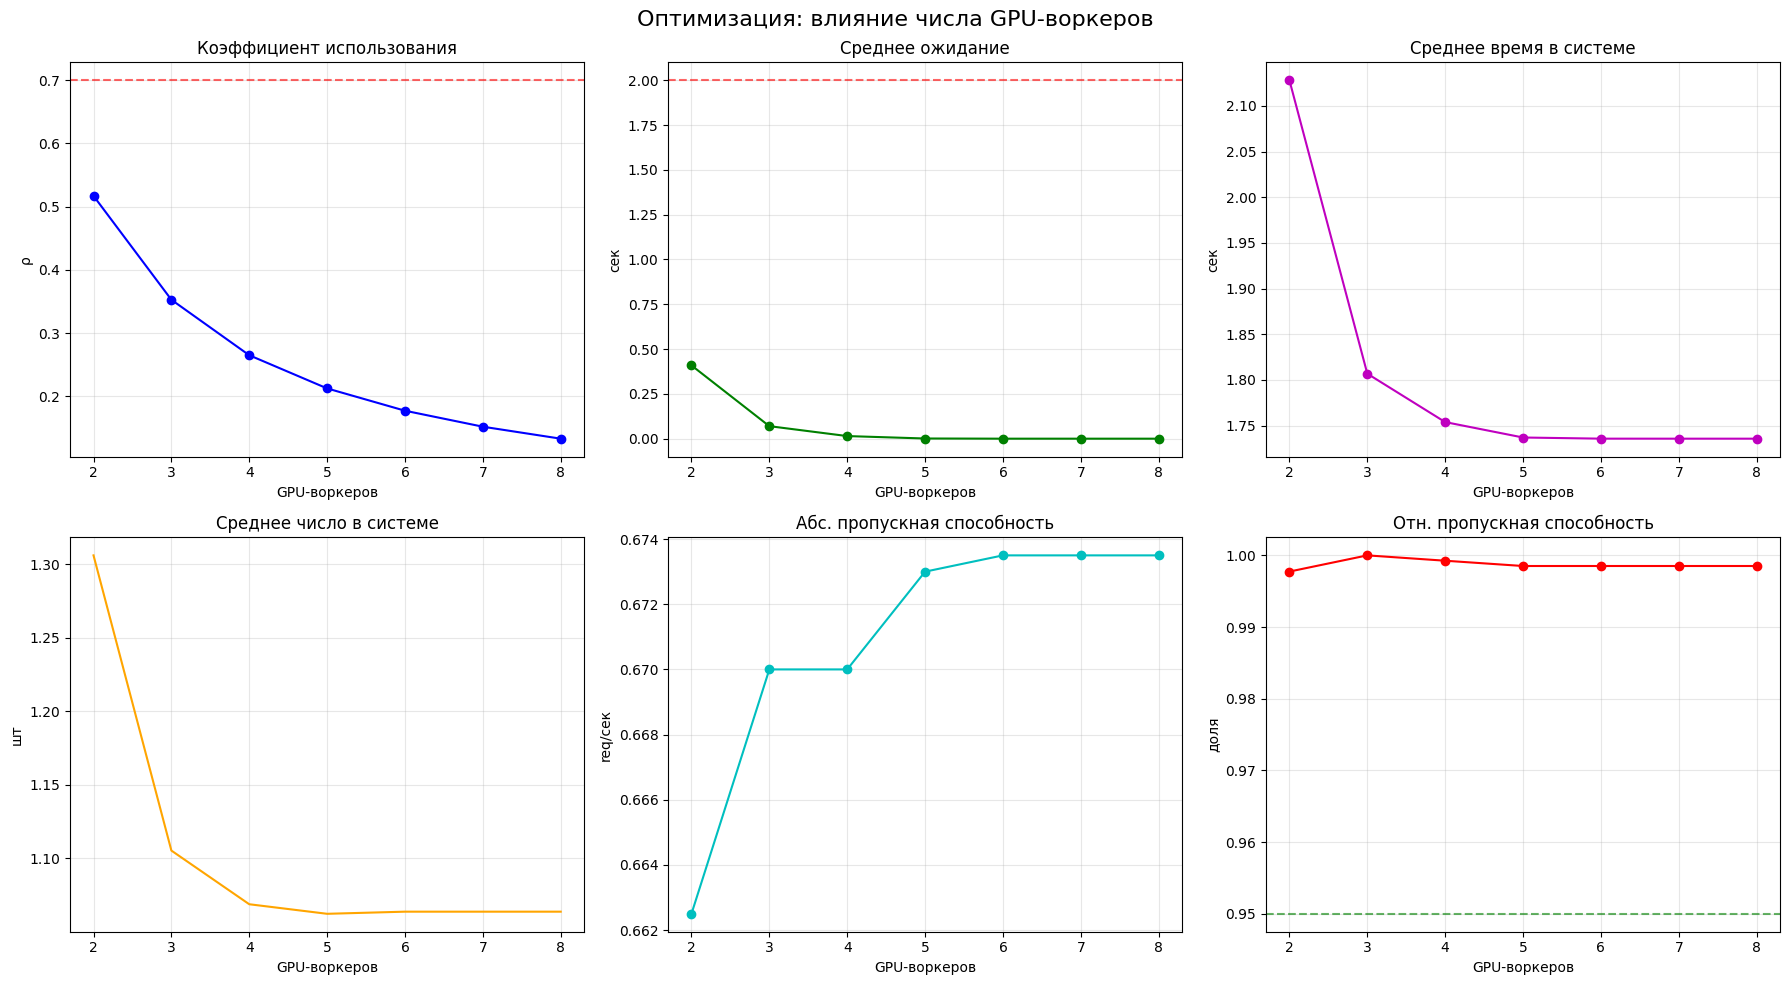

In [20]:
# Подготовка данных для графиков
s_list = [r['num_workers'] for r in results_grid]
util_list = [r['utilization'] for r in results_grid]
wait_list = [r['avg_wait'] for r in results_grid]
sys_time_list = [r['avg_system_time'] for r in results_grid]
n_list = [r['avg_in_system'] for r in results_grid]
thr_abs_list = [r['throughput_abs'] for r in results_grid]
thr_rel_list = [r['throughput_rel'] for r in results_grid]

fig, axes = plt.subplots(2, 3, figsize=(18, 10))
fig.suptitle('Оптимизация: влияние числа GPU‑воркеров', fontsize=16)

axes[0,0].plot(s_list, util_list, 'b-o'); axes[0,0].axhline(TARGET_UTIL_MIN, color='r', ls='--', alpha=0.6)
axes[0,0].set_title('Коэффициент использования'); axes[0,0].set_xlabel('GPU‑воркеров'); axes[0,0].set_ylabel('ρ')
axes[0,0].grid(alpha=0.3)

axes[0,1].plot(s_list, wait_list, 'g-o'); axes[0,1].axhline(TARGET_WAIT, color='r', ls='--', alpha=0.6)
axes[0,1].set_title('Среднее ожидание'); axes[0,1].set_xlabel('GPU‑воркеров'); axes[0,1].set_ylabel('сек')
axes[0,1].grid(alpha=0.3)

axes[0,2].plot(s_list, sys_time_list, 'm-o')
axes[0,2].set_title('Среднее время в системе'); axes[0,2].set_xlabel('GPU‑воркеров'); axes[0,2].set_ylabel('сек')
axes[0,2].grid(alpha=0.3)

axes[1,0].plot(s_list, n_list, 'orange')
axes[1,0].set_title('Среднее число в системе'); axes[1,0].set_xlabel('GPU‑воркеров'); axes[1,0].set_ylabel('шт')
axes[1,0].grid(alpha=0.3)

axes[1,1].plot(s_list, thr_abs_list, 'c-o')
axes[1,1].set_title('Абс. пропускная способность'); axes[1,1].set_xlabel('GPU‑воркеров'); axes[1,1].set_ylabel('req/сек')
axes[1,1].grid(alpha=0.3)

axes[1,2].plot(s_list, thr_rel_list, 'r-o'); axes[1,2].axhline(TARGET_REL_THR, color='g', ls='--', alpha=0.6)
axes[1,2].set_title('Отн. пропускная способность'); axes[1,2].set_xlabel('GPU‑воркеров'); axes[1,2].set_ylabel('доля')
axes[1,2].grid(alpha=0.3)

plt.tight_layout(); plt.show()

## Анализ чувствительности (интенсивность поступления)
Как меняются метрики при различных средних межприходах μ_A ∈ {1.0, 1.5, 2.0} в микросервисе обработки изображений?

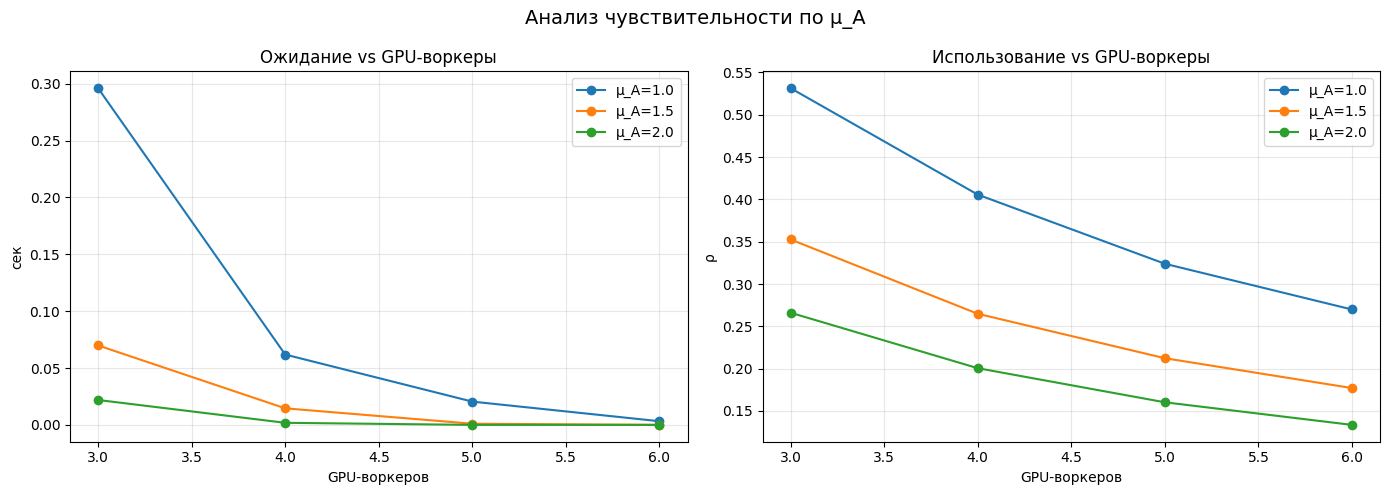

In [22]:
arrival_set = [1.0, 1.5, 2.0]
ops_to_test = [3, 4, 5, 6]
sens = {}
for a in arrival_set:
    sens[a] = [run_simulation(num_workers=s, num_preprocessors=1, mean_inference=1.5, mean_interarrival=a, sim_time=2000, seed=42) for s in ops_to_test]

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14,5))
fig.suptitle('Анализ чувствительности по μ_A', fontsize=14)

for a in arrival_set:
    ax1.plot([r['num_workers'] for r in sens[a]], [r['avg_wait'] for r in sens[a]], marker='o', label=f'μ_A={a}')
ax1.set_title('Ожидание vs GPU‑воркеры'); ax1.set_xlabel('GPU‑воркеров'); ax1.set_ylabel('сек'); ax1.grid(alpha=0.3); ax1.legend()

for a in arrival_set:
    ax2.plot([r['num_workers'] for r in sens[a]], [r['utilization'] for r in sens[a]], marker='o', label=f'μ_A={a}')
ax2.set_title('Использование vs GPU‑воркеры'); ax2.set_xlabel('GPU‑воркеров'); ax2.set_ylabel('ρ'); ax2.grid(alpha=0.3); ax2.legend()
plt.tight_layout(); plt.show()

## Примечания
- Все времена указаны в секундах.
- Вариантные параметры учтены: s=4, μ_s=1.5 сек (средний инференс), μ_A=1.5 сек (средний межприход).
- Быстрый шаг предобработки разгружает GPU‑воркеры от «мелких» операций перед инференсом.